# Import Library

In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from sklearn.metrics import classification_report
import os
import numpy as np
import pandas as pd

# Data Understanding

In [2]:
base_dir = 'E:/Godentist Dataset Capstone/Dataset Clear/data_set/tampak_atas'

In [3]:
print(os.listdir(base_dir))

['Bengkak Gusi', 'Bukan Gambar Gigi', 'Gigi Berlubang', 'Gigi Sehat', 'Plak Gigi']


In [4]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 2787


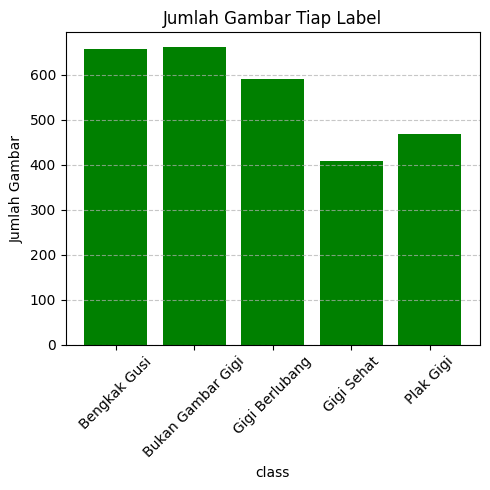

In [5]:
# Membuat plot dengan warna hijau
plt.figure(figsize=(5, 5))
plt.bar(number_label.keys(), number_label.values(), color='green')
plt.title("Jumlah Gambar Tiap Label")
plt.xlabel('class')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

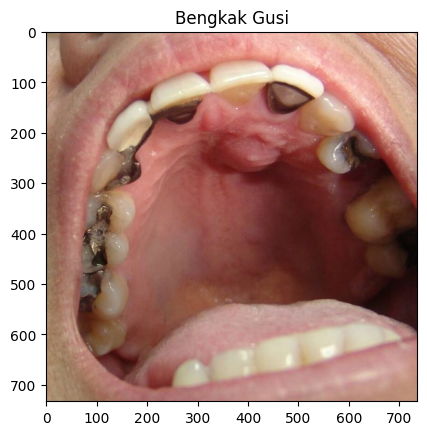

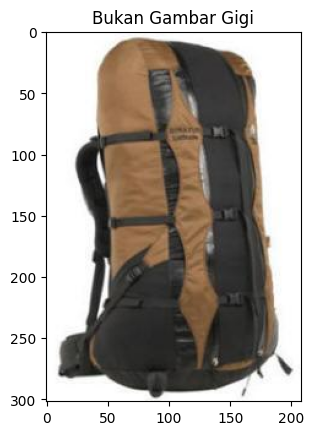

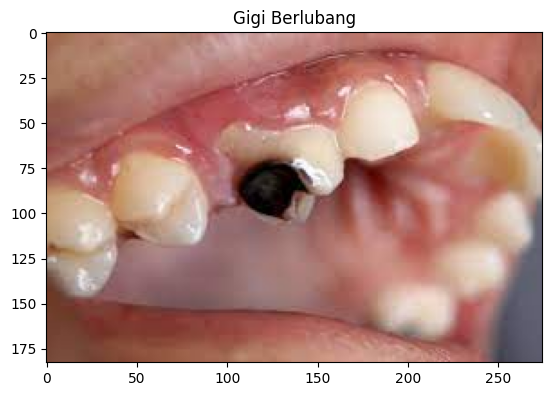

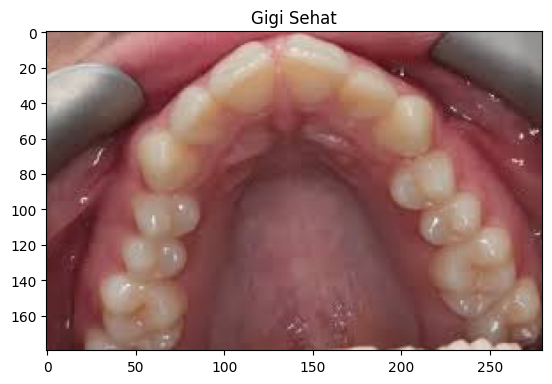

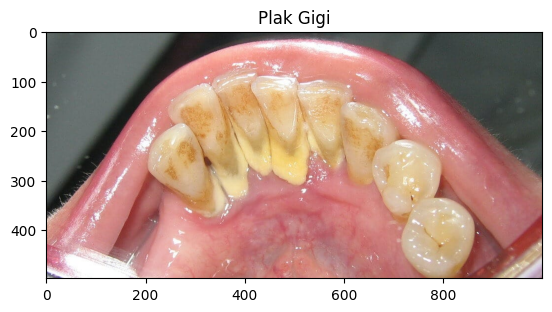

In [6]:
# Menampilkan sampel gambar tiap kelas
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

# Data Preparation

In [7]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
SEED = 999

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(validation_split=0.2,
                             rescale=1./255.,
                             rotation_range=20,
                             fill_mode = 'nearest')
#test_datagen = ImageDataGenerator(rescale = 1./255.)

In [9]:
#datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

In [10]:
# Menyiapkan data train dan data validation
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED 
)

Found 2229 images belonging to 5 classes.
Found 555 images belonging to 5 classes.


In [11]:
# Image Augmentation
'''data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

# Tambahkan lapisan Rescaling terpisah
data_augmentation.add(tf.keras.layers.Rescaling(1./255))
'''

'data_augmentation = tf.keras.Sequential(\n  [\n    tf.keras.layers.RandomFlip("horizontal",input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),\n    tf.keras.layers.RandomRotation(0.1),\n    tf.keras.layers.RandomZoom(0.1),\n  ]\n)\n\n# Tambahkan lapisan Rescaling terpisah\ndata_augmentation.add(tf.keras.layers.Rescaling(1./255))\n'

# Built Model Using Inception V3 Use Class Weight

In [12]:
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

In [13]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(5, activation='softmax')(x)

In [14]:
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [15]:
'''model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])'''

"model.compile(loss='categorical_crossentropy',\n              optimizer=tf.optimizers.Adam(),\n              metrics=['accuracy'])"

In [16]:
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

#callbacks = callbacks_list

In [17]:
from sklearn.utils.class_weight import compute_class_weight

# Dapatkan label dari generator
train_labels = train_data.classes

# Hitung class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# Compile dan train model dengan class weights
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])



In [19]:
validation_steps = valid_data.samples // BATCH_SIZE

history = model.fit(
      train_data,
      epochs=100,
      validation_data=valid_data,
      validation_steps=validation_steps,
      class_weight=class_weights)


Epoch 1/100
35/35 [==============================] - 110s 3s/step - loss: 1.3980 - accuracy: 0.6487 - val_loss: 0.5051 - val_accuracy: 0.8320
Epoch 2/100
35/35 [==============================] - 94s 3s/step - loss: 0.4903 - accuracy: 0.8286 - val_loss: 0.6638 - val_accuracy: 0.7695
Epoch 3/100
35/35 [==============================] - 94s 3s/step - loss: 0.3958 - accuracy: 0.8511 - val_loss: 0.4387 - val_accuracy: 0.8555
Epoch 4/100
35/35 [==============================] - 93s 3s/step - loss: 0.3455 - accuracy: 0.8780 - val_loss: 0.3760 - val_accuracy: 0.8867
Epoch 5/100
35/35 [==============================] - 97s 3s/step - loss: 0.2926 - accuracy: 0.9071 - val_loss: 0.3464 - val_accuracy: 0.8711
Epoch 6/100
35/35 [==============================] - 94s 3s/step - loss: 0.2611 - accuracy: 0.9116 - val_loss: 0.4058 - val_accuracy: 0.8633
Epoch 7/100
35/35 [==============================] - 96s 3s/step - loss: 0.2652 - accuracy: 0.9058 - val_loss: 0.3906 - val_accuracy: 0.8750
Epoch 8/100


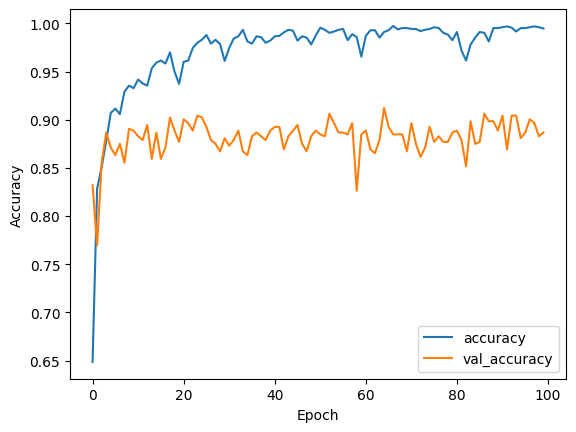

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

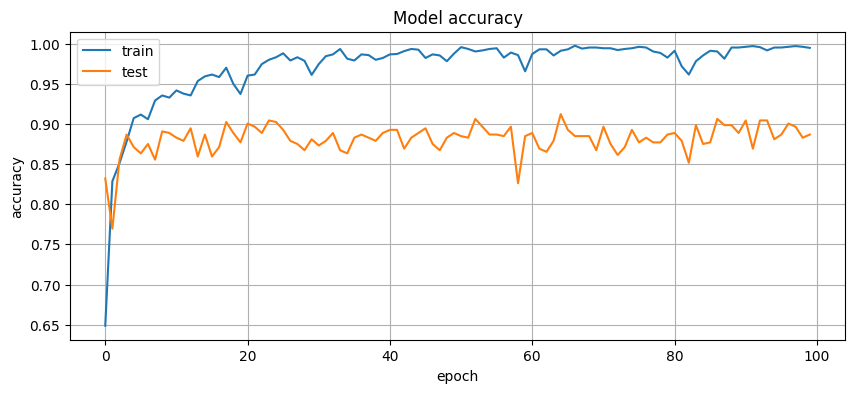

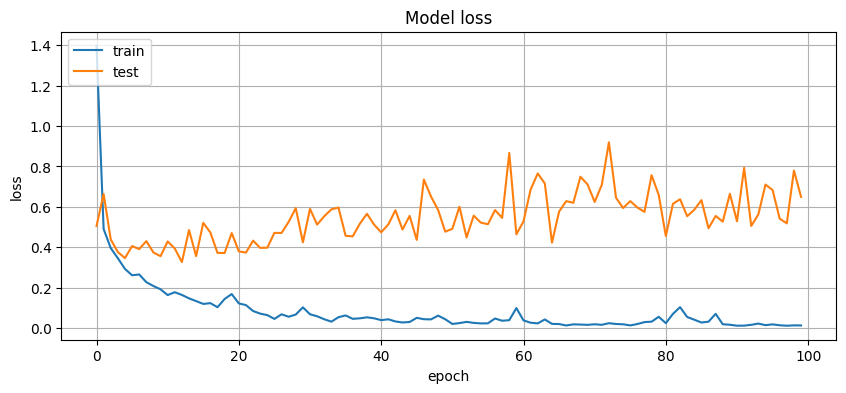

In [21]:
# Membuat plot akurasi model
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [22]:
# Evaluasi model pada data validasi
evaluation = model.evaluate(valid_data)

# Menampilkan hasil evaluasi
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

9/9 [==============================] - 21s 2s/step - loss: 0.6183 - accuracy: 0.8883
Loss: 0.6183345317840576
Accuracy: 0.8882882595062256


In [23]:
# save model
model.save('InceptionV3 history 2_model.h5')  # Simpan model dalam format .h5